#### 1) Change points for option price by Pelt
#### 2) What happens with iv at change point: Regression, ARIMA, Parametric test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
opt_prices_iv  = pd.read_csv('data/opt_prices_iv.csv')

In [9]:
opt_prices_iv = opt_prices_iv.set_index('date')
opt_prices_iv.index = pd.to_datetime(opt_prices_iv.index)

In [10]:
opt_prices_iv.head(5)

,price,underlying,daysToExp,bsm_iv
date,,,,
2022-10-06,6.25,144.767563,35,0.0354
2022-10-07,3.90,139.451889,34,0.0341
2022-10-10,4.22,139.780380,33,0.0336
2022-10-11,3.43,138.346954,32,0.0328
2022-10-12,3.30,137.709854,31,0.0321


# 1) Pelt

The PELT (Pruned Exact Linear Time) method is a an algorithm for detecting structural breaks detections. It is known for  efficiency and ability to provide exact solutions.

PELT starts by considering each data point as a potential candidate for a changing point. It assigns a cost to each candidate based on the likelihood of that point being a changing point. It then iterates through the data points in a specific order, calculating the cost of each candidate based on a statistical criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC). At each iteration, PELT prunes the candidates by eliminating those with higher costs, keeping only the most promising ones. This pruning process helps in reducing the computational complexity of the algorithm. PELT maintains a set of intervals representing the potential changing points. It updates these intervals as it progresses through the data, merging adjacent intervals if they have similar costs. The algorithm continues iterating through the data points until it reaches the end, evaluating all possible intervals. Finally, it selects the interval or intervals with the lowest cost as the detected structural breaks.


In [11]:
import ruptures as rpt

ts = opt_prices_iv['price']
y = np.array(ts.tolist())

algo = rpt.Pelt(model="l1")
algo.fit(y)
breaks = algo.predict(pen=3)

breaks_rpt = []
for i in breaks:
    breaks_rpt.append(ts.index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)
breaks_rpt

DatetimeIndex(['2022-10-19', '2022-11-02', '2022-11-09', '2022-11-25'], dtype='datetime64[ns]', freq=None)

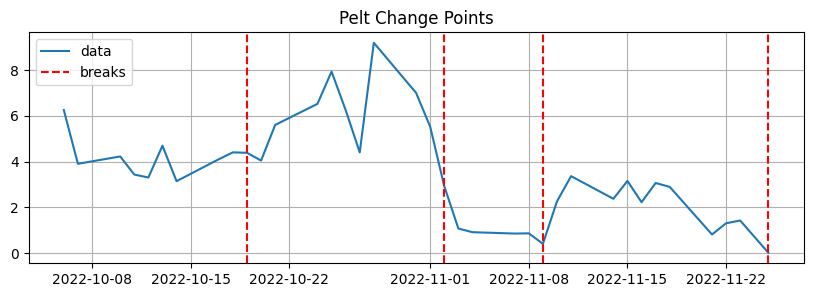

In [12]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)

plt.plot(ts, label='data')
plt.title('Pelt Change Points')

print_legend = True

for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

plt.grid()
plt.legend()
plt.show()

# 2) What happens with volatility at changing point

# Regression Analysis

### When determining the relations between option price and volatility it take the following forms:
### Positive Relationship:
   When volatility goes up, option prices tend to rise as well, it attributed to the concept of risk premium, since the higher volatility
   indicates increased uncertainty and risk in the market, leading to higher demand for options as a means of hedging or speculation.
   This increased demand drives up option prices.

### Nonlinear Relationship:
Nonetheless relationship between option price and volatility can be nonlinear, it can arise due to various factors such as the option's strike price, time to expiration, and the specific option pricing model.

### Market Conditions and News Events:
Market conditions and news events can significantly influence the relationship between option price and volatility. Major economic announcements, earnings reports, geopolitical events, or changes in market sentiment can all impact volatility levels and subsequently affect option prices.
During periods of heightened market uncertainty or significant news events, option prices may experience larger fluctuations and exhibit a stronger relationship with volatility.

In [15]:
from sklearn.linear_model import LinearRegression

In [25]:
def regression_analysis(df, change_point_date):
    X = df['price'].values.reshape(-1, 1)
    y = df['bsm_iv'].values


    # change_point_date = '2022-10-19'#'yyyy-mm-dd'
    before_change = df[:change_point_date]
    after_change = df[change_point_date:]


    regressor_before = LinearRegression()
    regressor_before.fit(before_change['price'].values.reshape(-1, 1), before_change['bsm_iv'].values)

    regressor_after = LinearRegression()
    regressor_after.fit(after_change['price'].values.reshape(-1, 1), after_change['bsm_iv'].values)

    print('Changing Point:', change_point_date)
    print()

    print('Before Changing Point:')
    print('Intercept:', regressor_before.intercept_)
    print('Coefficient:', regressor_before.coef_)
    print()

    print('After Changing Point:')
    print('Intercept:', regressor_after.intercept_)
    print('Coefficient:', regressor_after.coef_)

    # Plotting Graph

    plt.scatter(before_change['price'], before_change['bsm_iv'], color='blue', label='Before Changing Point')
    plt.plot(before_change['price'], regressor_before.predict(before_change['price'].values.reshape(-1, 1)), color='blue')

    plt.scatter(after_change['price'], after_change['bsm_iv'], color='red', label='After Changing Point')
    plt.plot(after_change['price'], regressor_after.predict(after_change['price'].values.reshape(-1, 1)), color='red')

    plt.xlabel('Option Price')
    plt.ylabel('Volatility')
    plt.legend()

    plt.show()


Changing Point: 2022-10-19

Before Changing Point:
Intercept: 0.02847742428508768
Coefficient: [0.00090949]

After Changing Point:
Intercept: 0.013074874185694335
Coefficient: [0.00212789]


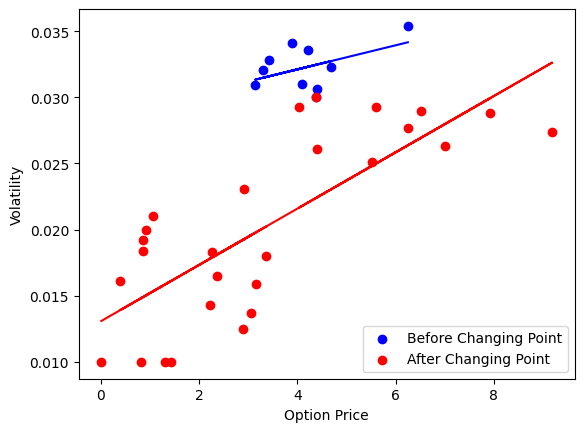

In [26]:
regression_analysis(df=opt_prices_iv, change_point_date='2022-10-19')

Changing Point: 2022-10-19 00:00:00

Before Changing Point:
Intercept: 0.02847742428508768
Coefficient: [0.00090949]

After Changing Point:
Intercept: 0.013074874185694335
Coefficient: [0.00212789]


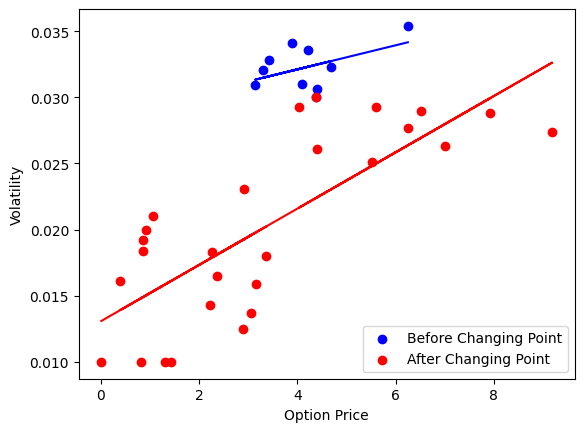

Changing Point: 2022-11-02 00:00:00

Before Changing Point:
Intercept: 0.03196314374725359
Coefficient: [-0.00043845]

After Changing Point:
Intercept: 0.014389764283592706
Coefficient: [0.0007493]


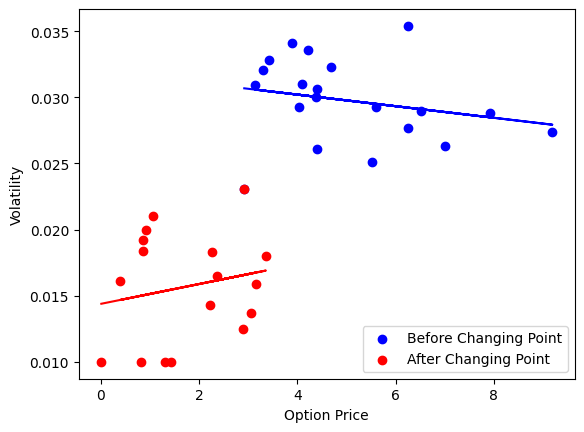

Changing Point: 2022-11-09 00:00:00

Before Changing Point:
Intercept: 0.022199791567872662
Coefficient: [0.00127867]

After Changing Point:
Intercept: 0.010688512192822847
Coefficient: [0.00159303]


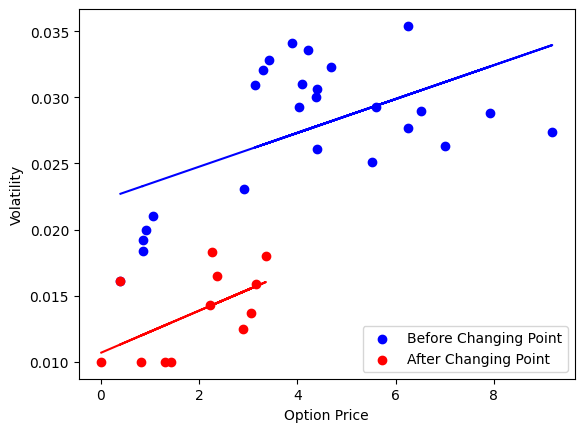

In [27]:
for i in range(len(breaks_rpt)-1): # exclude last one since no more data after
    regression_analysis(opt_prices_iv, breaks_rpt[i])

### Notice that we got regression coefficient close to 0, it indicates a weak or negligible linear relationship between option price volatility, which might be results of:

#### Weak Relationship.
A coefficient close to 0 suggests that there is little to no association between the option price and volatility. Changes in the option price are not significantly related to changes in volatility.

#### Nonlinear Relationship.
It could indicate a nonlinear relationship or a relationship that cannot be adequately captured by a simple linear regression model.

#### Other Factors.
The coefficient being close to 0 could imply that other factors or variables of external events not included in the regression model have a stronger influence on option volatility.

#### Insufficient Data.
Since current dataset is relatively small amd might lack sufficient information it can result in a coefficient close to 0.

### Thus, we need to conduct additional investigation.

# ARIMA
## Autoregressive Integrated Moving Average

#### Indeed it would be more sufficient to feed more data than we have now, but let's implement the model and hope for the better days with the better datasets.

In [29]:
from statsmodels.tsa.arima.model import ARIMA
data = opt_prices_iv

In [30]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['bsm_iv'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.015136
p-value: 0.959766
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary.

# d

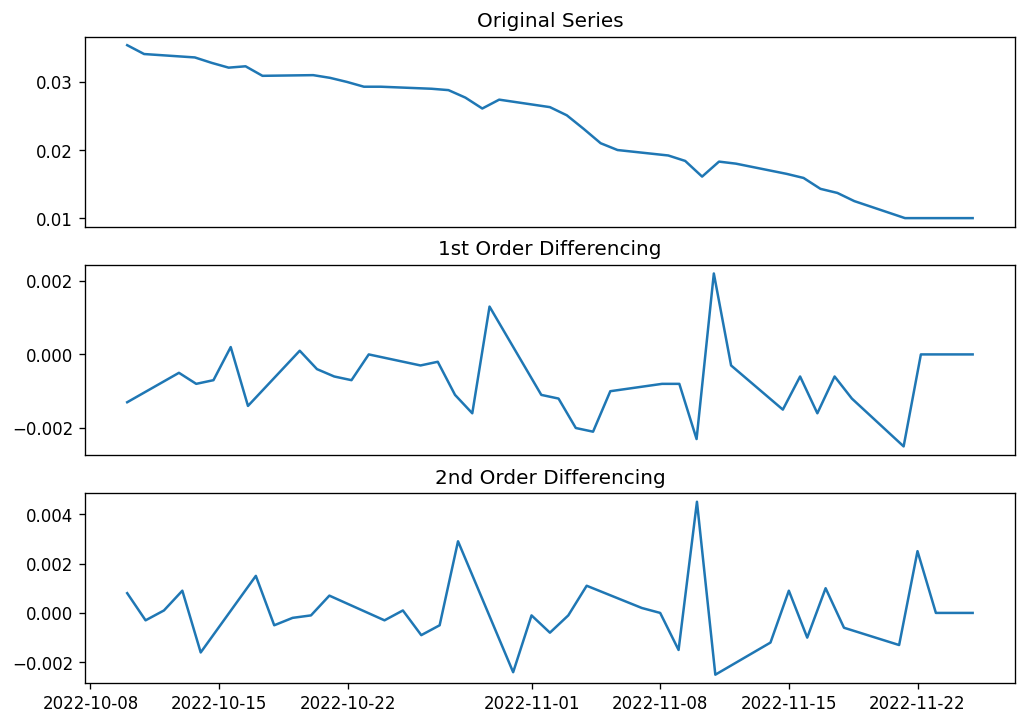

In [45]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(10, 7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data.bsm_iv); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data.bsm_iv.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data.bsm_iv.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

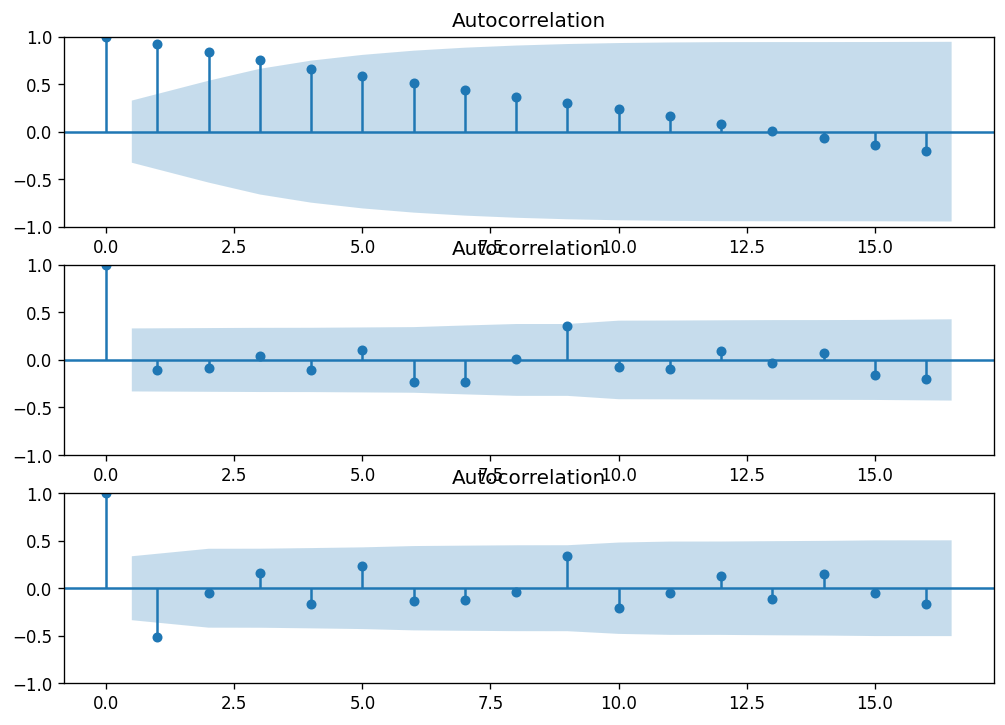

In [53]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data.bsm_iv, ax=ax1)
plot_acf(data.bsm_iv.diff().dropna(), ax=ax2)
plot_acf(data.bsm_iv.diff().diff().dropna(), ax=ax3)
plt.show()

# p

/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


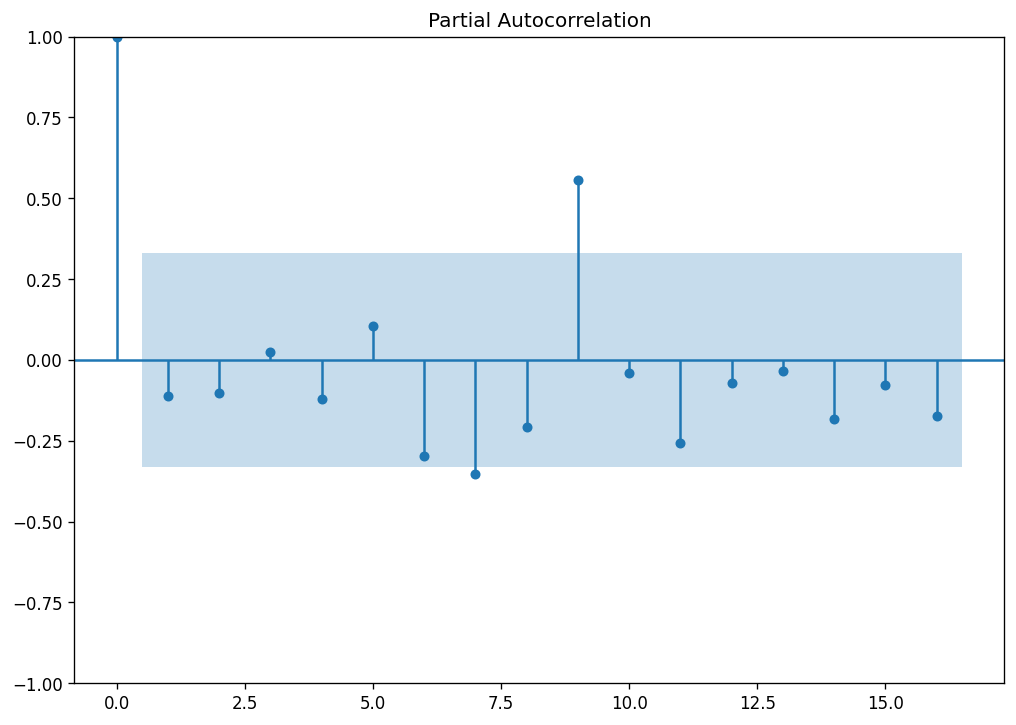

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.bsm_iv.diff().dropna())
plt.show()

# q

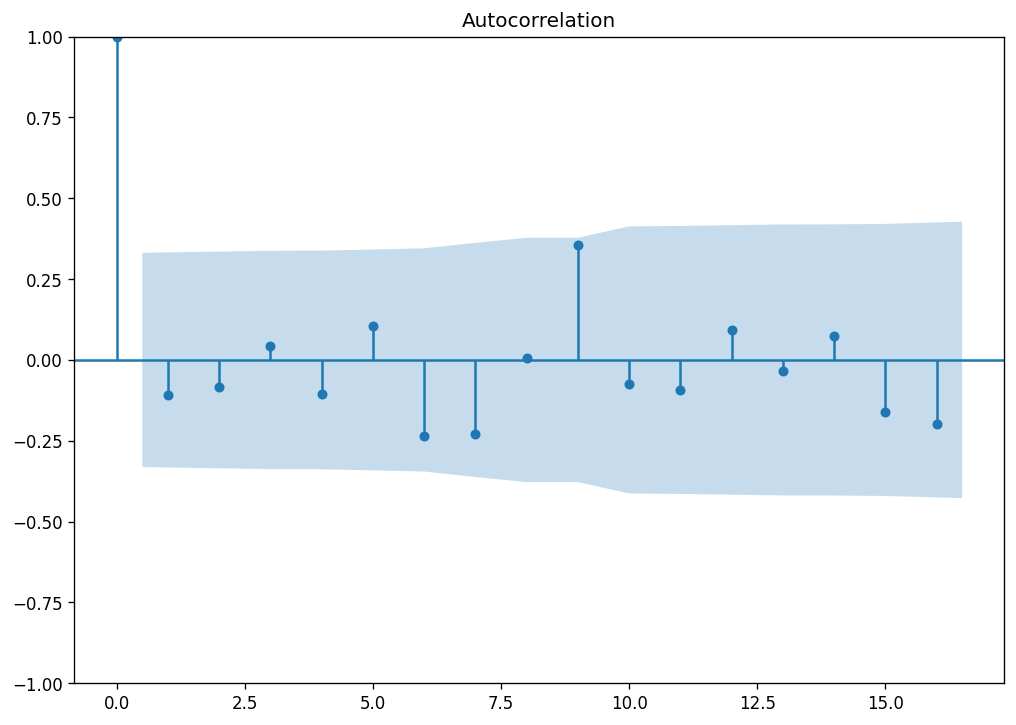

In [62]:
plot_acf(data.bsm_iv.diff().dropna())
plt.show()

In [80]:
p, d, q = 1, 1, 1

In [81]:
changing_point = pd.to_datetime('2022-10-18') # # 2022-10-19 so we will substitute 2022-10-18 for convenience in the next 2 lines
data_before = data[:changing_point]
data_after = data[changing_point:]


model_before = ARIMA(data_before['bsm_iv'], order=(p, d, q))
model_fit_before = model_before.fit()


model_after = ARIMA(data_after['bsm_iv'], order=(p, d, q))
model_fit_after = model_after.fit()


forecast_before = model_fit_before.forecast(steps=len(data_before))
forecast_after = model_fit_after.forecast(steps=len(data_after))


/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

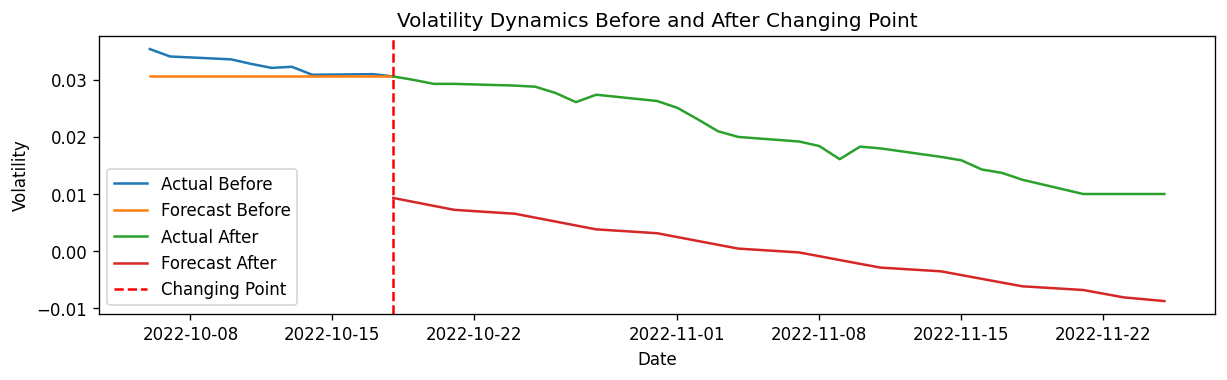

In [82]:
plt.figure(figsize=(12, 3))

plt.plot(data_before.index, data_before['bsm_iv'], label='Actual Before')
plt.plot(data_before.index, forecast_before, label='Forecast Before')

plt.plot(data_after.index, data_after['bsm_iv'], label='Actual After')
plt.plot(data_after.index, forecast_after, label='Forecast After')

plt.axvline(changing_point, color='r', linestyle='--', label='Changing Point')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.title('Volatility Dynamics Before and After Changing Point')
plt.legend()

plt.show()

# Parametric Test (T-test)
Again, more data - better

In [86]:
from scipy.stats import ttest_ind

In [92]:
def t_test(data, change_point_date):
    print(change_point_date)
    change_point_date = pd.to_datetime(change_point_date) - timedelta(days=1)

    changing_point = pd.to_datetime(change_point_date) # '2022-11-02' # 2022-10-19 so we will substitute 2022-10-18 for convenience in the next 2 lines
    data_before = data[:changing_point]
    data_after = data[changing_point:]

    volatility_before = data_before['bsm_iv']
    volatility_after = data_after['bsm_iv']

    # T-test
    t_stat, p_value = ttest_ind(volatility_before, volatility_after)


    print("T-Statistic: ", t_stat)
    print("P-Value: ", p_value)

    # Interpretations
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("There is a statistically significant difference in volatility before and after the changing point.")
    else:
        print("There is no statistically significant difference in volatility before and after the changing point.")


In [94]:
from datetime import datetime, timedelta
for i in breaks_rpt:
    t_test(data, i)
    print()
    print()

2022-10-19 00:00:00
T-Statistic:  4.989538133116304
P-Value:  1.6557796613048147e-05
There is a statistically significant difference in volatility before and after the changing point.


2022-11-02 00:00:00
T-Statistic:  11.04304632089435
P-Value:  5.938918772716465e-13
There is a statistically significant difference in volatility before and after the changing point.


2022-11-09 00:00:00
T-Statistic:  9.239183193476697
P-Value:  6.446404396733599e-11
There is a statistically significant difference in volatility before and after the changing point.


2022-11-25 00:00:00
T-Statistic:  nan
P-Value:  nan
There is no statistically significant difference in volatility before and after the changing point.




/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_1491/1458161964.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = ttest_ind(volatility_before, volatility_after)
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
